# Compare Different Features: MolLogP, Lipinski, RDKit Descriptors, Fingerprints, ...

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem
import tqdm

import ml
import utils
from analysis import CV, violinplot_bayesian_estimate_of_performance_metrics

c:\Users\GNZFG\AppData\Local\miniforge-pypy3\envs\AndroR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
andror_df_all = pd.read_csv("../andror_df_all_clusters.csv", index_col=0)

Use the same groups (Tanimoto threshold 0.65) for all trainings

In [3]:
groups = andror_df_all["cluster_065"]

# Generate Descriptors

This can take >45 minutes.

In [ ]:
rdkit_descriptors = {}

for idx, r in tqdm.tqdm(andror_df_all.iterrows(), desc="Calculating RDKit descriptors"):
    mol = Chem.MolFromSmiles(r["flat_smiles"])
    if mol is None:
        print("Error: Invalid SMILES string:", r["flat_smiles"])
        continue
    rdkit_descriptors[idx] = pd.Series(Chem.Descriptors.CalcMolDescriptors(mol))

rdkit_descriptors = pd.DataFrame(rdkit_descriptors).T

Calculating RDKit descriptors: 0it [00:00, ?it/s]

Calculating RDKit descriptors: 72686it [49:53, 24.28it/s]


Store the results in a .csv file for easy access later on because it took so long to calculate them.

In [ ]:
rdkit_descriptors.to_csv("rdkit_descriptors.csv")
# rdkit_descriptors = pd.read_csv("rdkit_descriptors.csv", index_col=0)

There's a single molecule where the RDKit descriptors have NA values. 
Drop this entry.

In [6]:
rdkit_descriptors = rdkit_descriptors.dropna()
andror_df_all = andror_df_all.loc[rdkit_descriptors.index]
groups = groups.loc[rdkit_descriptors.index]

# Lipinski

In [7]:
Lipinski_columns = ["MolWt", "NumHDonors", "NumHAcceptors", "MolLogP"]

In [8]:
splits_Lipinski, pipelines_Lipinski = ml.run_or_retrieve_from_disc(
    X=rdkit_descriptors[Lipinski_columns], 
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="Lipinski",
)

Repetitions:   0%|          | 0/5 [00:00<?, ?it/s]

Repetitions: 100%|██████████| 5/5 [15:02<00:00, 180.53s/it]


In [9]:
CV_Lipinski = CV(splits_Lipinski)

# RDKit descriptors

In [10]:
splits_rdkit_descriptors, pipelines_rdkit_descriptors = ml.run_or_retrieve_from_disc(
    X=rdkit_descriptors, 
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="RDKit_descriptors",
)

Repetitions:   0%|          | 0/5 [00:00<?, ?it/s]

Repetitions: 100%|██████████| 5/5 [4:47:06<00:00, 3445.24s/it]


In [11]:
CV_rdkit_descriptors = CV(splits_rdkit_descriptors)

# Fingerprints

In [12]:
andror_df_all = utils.add_fingerprints_to_df(andror_df_all)

Like the RDKit descriptors, we can store the fingerprints locally and use them later if desired.

In [13]:
andror_df_all[["flat_smiles"] + utils.FP_COLUMNS].to_csv("AndroR_4_final_fingerprints_ecpf6.csv")

In [14]:
splits_fingerprints, pipelines_fingerprints = ml.run_or_retrieve_from_disc(
    X=andror_df_all[utils.FP_COLUMNS], 
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="tanimoto_065", # this will reuse the model from fingerprint_based_clustering.ipynb
)

In [15]:
CV_fingerprints = CV(splits_fingerprints)

# Fingerprints Top 5

In [ ]:
top5_fingerprints = ['fp_893', 'fp_659', 'fp_486', 'fp_561', 'fp_650']

In [17]:
splits_fingerprints_top5, pipelines_fingerprints_top5 = ml.run_or_retrieve_from_disc(
    X=andror_df_all[top5_fingerprints], 
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="fingerprints_top5",
)

Repetitions: 100%|██████████| 5/5 [20:04<00:00, 240.95s/it]


In [18]:
CV_fingerprints_top5 = CV(splits_fingerprints_top5)

# Fingerprints Excl. Top 5

In [19]:
fingerprints_excl_top_5 = [col for col in utils.FP_COLUMNS if col not in top5_fingerprints]

In [20]:
splits_fingerprints_excl_top5, pipelines_fingerprints_excl_top5 = ml.run_or_retrieve_from_disc(
    X=andror_df_all[fingerprints_excl_top_5], 
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="fingerprints_excl_top5",
)

Repetitions: 100%|██████████| 5/5 [1:03:05<00:00, 757.16s/it]


In [21]:
CV_fingerprints_excl_top5 = CV(splits_fingerprints_excl_top5)

# RDKit Descriptors + Fingerprints

In [22]:
splits_rdkit_descriptors_and_fingerprints, pipelines_rdkit_descriptors_and_fingerprints = ml.run_or_retrieve_from_disc(
    X=pd.concat([andror_df_all[utils.FP_COLUMNS], rdkit_descriptors], axis=1), 
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="RDKit_descriptors_and_fingerprints",
)

Repetitions: 100%|██████████| 5/5 [3:42:03<00:00, 2664.78s/it]


In [23]:
CV_rdkit_descriptors_and_fingerprints = CV(splits_rdkit_descriptors_and_fingerprints)

# Only SlogP_VSA2 - RDKit Descriptor with Highest SHAP Value

In [44]:
splits_SlogP_VSA2, _ = ml.run_or_retrieve_from_disc(
    X=rdkit_descriptors[["SlogP_VSA2"]], 
    y=andror_df_all["final class"], 
    groups=andror_df_all["cluster_065"], 
    training_name="SlogP_VSA2",
)

Repetitions: 100%|██████████| 5/5 [07:45<00:00, 93.11s/it]


In [45]:
CV_SlogP_VSA2 = CV(splits_SlogP_VSA2)

# RDKit descriptors excluding SlogP_VSA2

In [49]:
splits_rdkit_descriptors_excl_SlogP_VSA2, pipelines_rdkit_descriptors_excl_SlogP_VSA2 = ml.run_or_retrieve_from_disc(
    X=rdkit_descriptors.drop(columns=["SlogP_VSA2"]), 
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="RDKit_descriptors_excl_SlogP_VSA2",
)

Repetitions: 100%|██████████| 5/5 [5:54:44<00:00, 4256.83s/it]  


In [50]:
CV_rdkit_descriptors_excl_SlogP_VSA2 = CV(splits_rdkit_descriptors_excl_SlogP_VSA2)

# Compare all results

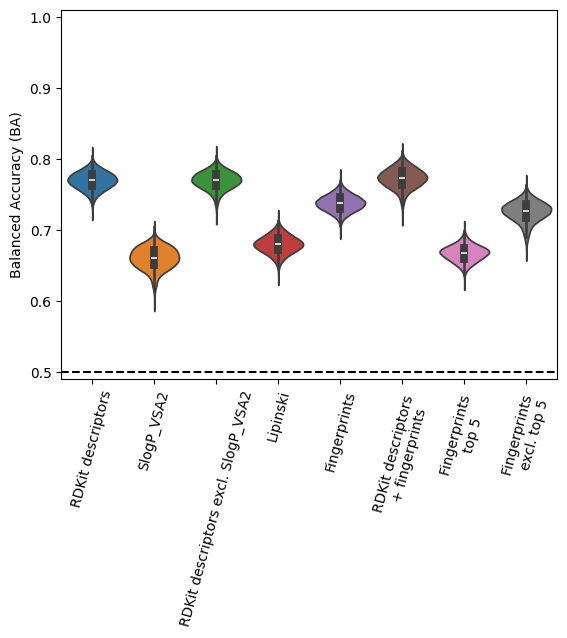

In [57]:
comparison_df_CV = violinplot_bayesian_estimate_of_performance_metrics({
    "RDKit descriptors": CV_rdkit_descriptors,
    "SlogP_VSA2": CV_SlogP_VSA2,
    "RDKit descriptors excl. SlogP_VSA2": CV_rdkit_descriptors_excl_SlogP_VSA2,
    "Lipinski": CV_Lipinski,
    "Fingerprints": CV_fingerprints,
    "RDKit descriptors \n+ fingerprints": CV_rdkit_descriptors_and_fingerprints,
    "Fingerprints \n top 5": CV_fingerprints_top5,
    "Fingerprints \n excl. top 5": CV_fingerprints_excl_top5,
}, sel_metric="balanced accuracy")

In [53]:
comparison_df_CV.describe().loc[["mean", "std"]]

,RDKit descriptors,SlogP_VSA2,RDKit descriptors excl. SlogP_VSA2,Lipinski,Fingerprints,RDKit descriptors \n+ fingerprints,Fingerprints \n top 5,Fingerprints \n excl. top 5
mean,0.769569,0.660416,0.769797,0.679731,0.737951,0.77300,0.667459,0.726060
std,0.012362,0.015528,0.012666,0.012466,0.011384,0.01387,0.011380,0.014501


# Plot NPV-TNR Curve for RDKit Descriptor Model

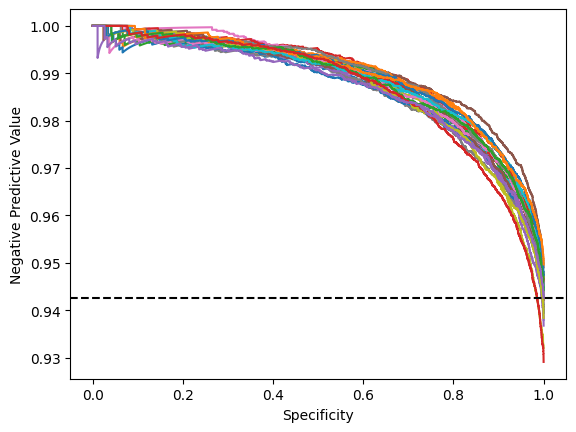

In [30]:
CV_rdkit_descriptors.plot_npv_tnr_curve()